# Model with the error correctness and with Green data (Xout)

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
from keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [62]:
# loading the data
df = pd.read_excel("103_upset (around 21000 points).xls", header= 3)
df.head(6)

,Time,,Flow,Flow.1,Flow.2,Flow.3,Flow.4,Flow.5,Press,Press.1,...,Press.4,Press.5,Press.6,Press.7,Temp,Temp.1,Temp.2,Temp.3,Temp.4,oxygen
0,NaN,NaN,BFW,BFW,Steam,Steam,Fuel gas,Air,FD disch,Fuel gas,...,ignitor,steam drm,steam drm,flue gas,Dertor,steam drm,super,super,flue gas,%
1,NaN,,92fi300.pv,92fy300.pv,92fi301.pv,92fi301.pv,92fi305.pv,92fi302.pv,92pi317.pv,92pi311.pv,...,92pi324.pv,92pi307.pv,92pi301.pv,92pi300.pv,93ti211.pv,92ti300a.pv,92ti300b.pv,92ti311.pv,92ti300.pv,92ai300.pv
2,NaN,2008-06-21 07:00:00,355.848491,355.234993,352.095325,352.095325,401.596232,1.12351,9.716322,7.576174,...,7.780427,628.271028,649.402659,0.310961,298.276672,597.732324,760.399808,765.36439,335.989723,2.05269
3,NaN,2008-06-21 07:00:01,355.877026,355.345775,354.608066,354.608066,401.471854,1.111719,9.716363,7.576189,...,7.780427,628.270974,649.402513,0.310964,298.276689,597.732295,760.399987,765.36489,335.989571,2.030534
4,NaN,2008-06-21 07:00:02,355.90556,355.456557,356.111179,356.111179,401.347476,1.099927,9.716405,7.576205,...,7.780427,628.270921,649.402367,0.310968,298.276707,597.732267,760.400165,765.36539,335.989419,2.018448
5,NaN,2008-06-21 07:00:03,355.934095,355.567339,356.604663,356.604663,401.223098,1.088136,9.716447,7.57622,...,7.780428,628.270868,649.402221,0.310972,298.276724,597.732239,760.400343,765.36589,335.989267,2.016434


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     0 non-null      float64
 1            21601 non-null  object 
 2   Flow     21602 non-null  object 
 3   Flow.1   21602 non-null  object 
 4   Flow.2   21602 non-null  object 
 5   Flow.3   21602 non-null  object 
 6   Flow.4   21602 non-null  object 
 7   Flow.5   21602 non-null  object 
 8   Press    21602 non-null  object 
 9   Press.1  21602 non-null  object 
 10  Press.2  21602 non-null  object 
 11  Press.3  21602 non-null  object 
 12  Press.4  21602 non-null  object 
 13  Press.5  21602 non-null  object 
 14  Press.6  21602 non-null  object 
 15  Press.7  21602 non-null  object 
 16  Temp     21602 non-null  object 
 17  Temp.1   21602 non-null  object 
 18  Temp.2   21602 non-null  object 
 19  Temp.3   21602 non-null  object 
 20  Temp.4   21602 non-null  object 
 21  oxygen   216

# Preprocessing

In [64]:
#Droping First colmun and First two rows
df=df.drop([0,1], axis=0)
df = df.drop(df.iloc[:,0:1],axis = 1)

In [65]:
df.head()

,,Flow,Flow.1,Flow.2,Flow.3,Flow.4,Flow.5,Press,Press.1,Press.2,...,Press.4,Press.5,Press.6,Press.7,Temp,Temp.1,Temp.2,Temp.3,Temp.4,oxygen
2,2008-06-21 07:00:00,355.848491,355.234993,352.095325,352.095325,401.596232,1.12351,9.716322,7.576174,0.008244,...,7.780427,628.271028,649.402659,0.310961,298.276672,597.732324,760.399808,765.36439,335.989723,2.05269
3,2008-06-21 07:00:01,355.877026,355.345775,354.608066,354.608066,401.471854,1.111719,9.716363,7.576189,0.008244,...,7.780427,628.270974,649.402513,0.310964,298.276689,597.732295,760.399987,765.36489,335.989571,2.030534
4,2008-06-21 07:00:02,355.90556,355.456557,356.111179,356.111179,401.347476,1.099927,9.716405,7.576205,0.008245,...,7.780427,628.270921,649.402367,0.310968,298.276707,597.732267,760.400165,765.36539,335.989419,2.018448
5,2008-06-21 07:00:03,355.934095,355.567339,356.604663,356.604663,401.223098,1.088136,9.716447,7.57622,0.008245,...,7.780428,628.270868,649.402221,0.310972,298.276724,597.732239,760.400343,765.36589,335.989267,2.016434
6,2008-06-21 07:00:04,355.96263,355.678121,355.491806,355.491806,401.09872,1.083197,9.716489,7.576236,0.008246,...,7.780428,628.270815,649.402075,0.310976,298.276742,597.73221,760.400521,765.366391,335.989115,2.01442


In [66]:
colWithTime=['Time','Flow BFW/ 92fi300.pv', 'Flow BFW/92fy300.pv','Flow Steam/92fi301.pv', 'Flow Steam/92fi301.pv.1', 'Flow Fuel gas/92fi305.pv', 'Flow Air/92fi302.pv', 'Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv', 'Press Fuel gas/92pi304.pv', 'Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Press flue gas/92pi300.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv','Temp super/92ti311.pv','Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv']
df.columns = colWithTime
col=['Flow BFW/ 92fi300.pv', 'Flow BFW/92fy300.pv','Flow Steam/92fi301.pv', 'Flow Steam/92fi301.pv.1', 'Flow Fuel gas/92fi305.pv', 'Flow Air/92fi302.pv', 'Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv', 'Press Fuel gas/92pi304.pv', 'Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Press flue gas/92pi300.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv','Temp super/92ti311.pv','Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv']
df[col] = df[col].apply(pd.to_numeric, errors= 'coerce', downcast= 'float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 2 to 21601
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Time                        21600 non-null  object 
 1   Flow BFW/ 92fi300.pv        21510 non-null  float32
 2   Flow BFW/92fy300.pv         21582 non-null  float32
 3   Flow Steam/92fi301.pv       21582 non-null  float32
 4   Flow Steam/92fi301.pv.1     21582 non-null  float32
 5   Flow Fuel gas/92fi305.pv    21582 non-null  float32
 6   Flow Air/92fi302.pv         21582 non-null  float32
 7   Press FD disch/92pi317.pv   21582 non-null  float32
 8   Press Fuel gas/92pi311.pv   21582 non-null  float32
 9   Press Fuel gas/92pi304.pv   21582 non-null  float32
 10  Press furnce/92pi306.pv     21582 non-null  float32
 11  Press ignitor /92pi324.pv   21582 non-null  float32
 12  Press steam drm/92pi307.pv  21582 non-null  float32
 13  Press steam drm/92pi301.pv  215

In [67]:
# filling the null values of Press flue gas/92pi300.pv by the mean value
df['Press flue gas/92pi300.pv']= df['Press flue gas/92pi300.pv'].fillna(df['Press flue gas/92pi300.pv'].mean())
df['Press flue gas/92pi300.pv'].describe()

count    21600.000000
mean         0.335788
std          0.032409
min          0.276383
25%          0.308812
50%          0.335786
75%          0.361206
max          0.418377
Name: Press flue gas/92pi300.pv, dtype: float64

In [68]:
df['Time']= df['Time'].apply(pd.to_datetime ,errors= 'coerce' )

# dropping features marked us not needed for the model (Black)
df = df.drop("Flow BFW/92fy300.pv",axis = 1)
df = df.drop("Flow Steam/92fi301.pv",axis = 1)
df = df.drop("Temp super/92ti311.pv",axis = 1)

In [69]:
# colToBeDropped = ['Press FD disch/92pi317.pv', 'Press Fuel gas/92pi311.pv','Press furnce/92pi306.pv', 'Press ignitor /92pi324.pv','Press steam drm/92pi307.pv', 'Press steam drm/92pi301.pv','Temp Dertor /93ti211.pv','Temp steam drm/92ti300a.pv','Temp super/92ti300b.pv']
# df = df.drop(colToBeDropped,axis = 1)

In [70]:
display(df)

,Time,Flow BFW/ 92fi300.pv,Flow Steam/92fi301.pv.1,Flow Fuel gas/92fi305.pv,Flow Air/92fi302.pv,Press FD disch/92pi317.pv,Press Fuel gas/92pi311.pv,Press Fuel gas/92pi304.pv,Press furnce/92pi306.pv,Press ignitor /92pi324.pv,Press steam drm/92pi307.pv,Press steam drm/92pi301.pv,Press flue gas/92pi300.pv,Temp Dertor /93ti211.pv,Temp steam drm/92ti300a.pv,Temp super/92ti300b.pv,Temp flue gas/92ti300.pv,oxygen% /92ai300.pv
2,2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,0.008244,3.716083,7.780427,628.271057,649.402649,0.310961,298.276672,597.732300,760.399780,335.989716,2.052690
3,2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,0.008244,3.716082,7.780427,628.270996,649.402527,0.310964,298.276703,597.732300,760.399963,335.989563,2.030534
4,2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,9.716405,7.576205,0.008245,3.716082,7.780427,628.270935,649.402344,0.310968,298.276703,597.732239,760.400146,335.989410,2.018448
5,2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,9.716447,7.576221,0.008245,3.716082,7.780428,628.270874,649.402222,0.310972,298.276733,597.732239,760.400330,335.989258,2.016434
6,2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,9.716489,7.576236,0.008246,3.716081,7.780428,628.270813,649.402100,0.310976,298.276733,597.732239,760.400513,335.989105,2.014420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597,2008-06-21 12:59:55,355.894012,355.310516,384.652435,1.079072,9.662274,6.908769,0.050951,3.449764,7.674482,633.258545,657.526001,0.317213,299.992676,605.804993,768.476746,355.115173,1.953448
21598,2008-06-21 12:59:56,355.618317,354.761658,384.477875,1.083946,9.661740,6.908767,0.050951,3.449861,7.674482,633.258057,657.524597,0.319882,299.992676,605.795837,768.476196,355.113800,1.955882
21599,2008-06-21 12:59:57,355.342621,356.987366,383.877808,1.085681,9.661206,6.908764,0.050951,3.449958,7.674482,633.257568,657.523254,0.322551,299.992676,605.786682,768.475586,355.112396,1.958315
21600,2008-06-21 12:59:58,355.066925,356.524109,384.063263,1.087415,9.660672,6.908762,0.050951,3.450054,7.674482,633.257141,657.521851,0.325220,299.992676,605.777588,768.475037,355.111023,1.960749


In [71]:
df = df.dropna()

In [72]:
df.index = df.pop('Time')
df.head()

,Flow BFW/ 92fi300.pv,Flow Steam/92fi301.pv.1,Flow Fuel gas/92fi305.pv,Flow Air/92fi302.pv,Press FD disch/92pi317.pv,Press Fuel gas/92pi311.pv,Press Fuel gas/92pi304.pv,Press furnce/92pi306.pv,Press ignitor /92pi324.pv,Press steam drm/92pi307.pv,Press steam drm/92pi301.pv,Press flue gas/92pi300.pv,Temp Dertor /93ti211.pv,Temp steam drm/92ti300a.pv,Temp super/92ti300b.pv,Temp flue gas/92ti300.pv,oxygen% /92ai300.pv
Time,,,,,,,,,,,,,,,,,
2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,0.008244,3.716083,7.780427,628.271057,649.402649,0.310961,298.276672,597.732300,760.399780,335.989716,2.052690
2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,0.008244,3.716082,7.780427,628.270996,649.402527,0.310964,298.276703,597.732300,760.399963,335.989563,2.030534
2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,9.716405,7.576205,0.008245,3.716082,7.780427,628.270935,649.402344,0.310968,298.276703,597.732239,760.400146,335.989410,2.018448
2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,9.716447,7.576221,0.008245,3.716082,7.780428,628.270874,649.402222,0.310972,298.276733,597.732239,760.400330,335.989258,2.016434
2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,9.716489,7.576236,0.008246,3.716081,7.780428,628.270813,649.402100,0.310976,298.276733,597.732239,760.400513,335.989105,2.014420


# LSTM data preperation

In [73]:
# defining the input columns
# PFG = df.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)
# PFG.shape

In [74]:
# defining the output columns
# ypf1= df[['Temp flue gas/92ti300.pv']]
# ypf1= ypf1.to_numpy()
# ypf1= ypf1.reshape(-1,1)

# ypf2= df[['oxygen% /92ai300.pv']]
# ypf2= ypf2.to_numpy()
# ypf2= ypf2.reshape(-1,1)

# ypf3= df[['Press Fuel gas/92pi304.pv']]
# ypf3= ypf3.to_numpy()
# ypf3= ypf3.reshape(-1,1)

# ypf4= df[['Press flue gas/92pi300.pv']]
# ypf4= ypf4.to_numpy()
# ypf4= ypf4.reshape(-1,1)

In [75]:
# from sklearn.preprocessing import StandardScaler


# s =StandardScaler()
# s2 =StandardScaler()
# s= s.fit(PFG)
# s2= s2.fit(ypf1)
# s2= s2.fit(ypf2)
# s2= s2.fit(ypf3)
# s2= s2.fit(ypf4)

# PFG= s.transform(PFG)
# ypf1=s2.transform(ypf1)
# ypf2=s2.transform(ypf2) 
# ypf3=s2.transform(ypf3) 
# ypf4=s2.transform(ypf4) 

# PFG = pd.DataFrame(PFG)
# PFG['12'] = ypf1
# PFG['13'] = ypf2
# PFG['14'] = ypf3
# PFG['15'] = ypf4
# display(PFG)
# PFG= PFG.to_numpy()

In [76]:
# reshaping the data

# X= []
# y= []
# n1= 1
# n2= 10
# for i in range(n2, len(PFG)-n1 +1):
#     X.append(PFG[i-n2 : i, 0: PFG.shape[1]])
#     y.append(PFG[i+n1-1:i+n1,12:16])
    

In [77]:
# X, y =np.array(X), np.array(y)
# X.shape , y.shape

In [78]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Model data preperation


In [79]:
train, test = train_test_split(df, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [80]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop("Press Fuel gas/92pi304.pv")
    y1 = np.array(y1)
    y2 = data.pop('Press flue gas/92pi300.pv')
    y2 = np.array(y2)
    y3 = data.pop('Temp flue gas/92ti300.pv')
    y3 = np.array(y3)
    y4 = data.pop('oxygen% /92ai300.pv')
    y4 = np.array(y4)
    
    return y1, y2, y3, y4

In [81]:
# Get the 4 outputs and format them as np arrays

train_stats = train.describe()
train_stats.pop('Press Fuel gas/92pi304.pv')
train_stats.pop('Press flue gas/92pi300.pv')
train_stats.pop('Temp flue gas/92ti300.pv')
train_stats.pop('oxygen% /92ai300.pv')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)

                              count        mean        std         min  \
Flow BFW/ 92fi300.pv        13756.0  395.721436  45.131226  310.974976   
Flow Steam/92fi301.pv.1     13756.0  396.710876  44.638016  338.026001   
Flow Fuel gas/92fi305.pv    13756.0  435.069702  43.243805  366.696686   
Flow Air/92fi302.pv         13756.0    1.377588   0.326439    0.999363   
Press FD disch/92pi317.pv   13756.0   11.341043   2.124070    9.287875   
Press Fuel gas/92pi311.pv   13756.0    8.900289   1.634700    6.908760   
Press furnce/92pi306.pv     13756.0    4.775886   1.374391    3.230302   
Press ignitor /92pi324.pv   13756.0    7.734364   0.038052    7.674482   
Press steam drm/92pi307.pv  13756.0  630.171204   5.273255  597.887512   
Press steam drm/92pi301.pv  13756.0  656.885742   8.244145  643.708191   
Temp Dertor /93ti211.pv     13756.0  298.350891   1.194582  291.347595   
Temp steam drm/92ti300a.pv  13756.0  615.839294  18.611631  597.643372   
Temp super/92ti300b.pv      13756.0  7

In [82]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

# Modeling

In [83]:
# # Model with 4 layers including the output column
# def build_model():
#     # Define model layers.
#     input_layer0 = Input(shape=(len(train .columns),))
    
# #     lstm_layer = LSTM(128)
#     hidden1 = Dense(128, activation='relu')(input_layer0)
#     hidden2 = Dense(128, activation='relu')(hidden1)
    
#     #(lstm_layer)
#     y1_output = Dense(units='1', name='PressFuelGas304_output')(hidden2)
#     y2_output = Dense(units='1', name='PressFlueGas300_output')(hidden2)
#     y3_output = Dense(units='1', name='TempFlueGas_output')(hidden2)
#     y4_output = Dense(units='1', name='Oxygen_output')(hidden2)
    
#     # Define the model with the input layer and a list of output layers
#     model = Model(inputs=input_layer0, outputs=[y1_output, y2_output,y3_output,y4_output])
#     return model

In [96]:
# Model with 5 layers including the output column
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    
#Model with 5 layers including the output column
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    
    # 5L 
#     hidden1 = Dense(128, activation='relu')(input_layer)
#     hidden2 = Dense(128, activation='relu')(hidden1)
#     hidden3 = Dense(64, activation='relu')(hidden2)


    # 5L 128/64/32
    hidden1 = Dense(128, activation='relu')(input_layer)
    hidden2 = Dense(64, activation='relu')(hidden1)
    hidden3 = Dense(32, activation='relu')(hidden2)
    

    #(lstm_layer)
    y1_output = Dense(units='1', name='PressFuelGas304_output')(hidden3)
    y2_output = Dense(units='1', name='PressFlueGas300_output')(hidden3)
    y3_output = Dense(units='1', name='TempFlueGas_output')(hidden3)
    y4_output = Dense(units='1', name='Oxygen_output')(hidden3)
    
    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output,y3_output,y4_output])
    return model
    
    #(lstm_layer)
    y1_output = Dense(units='1', name='PressFuelGas304_output')(hidden3)
    y2_output = Dense(units='1', name='PressFlueGas300_output')(hidden3)
    y3_output = Dense(units='1', name='TempFlueGas_output')(hidden3)
    y4_output = Dense(units='1', name='Oxygen_output')(hidden3)
    
    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output,y3_output,y4_output])
    return model

In [97]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'PressFuelGas304_output': 'mse', 'PressFlueGas300_output': 'mse','TempFlueGas_output': 'mse','Oxygen_output': 'mse'},
              metrics={'PressFuelGas304_output': tf.keras.metrics.RootMeanSquaredError(),
                       'PressFlueGas300_output': tf.keras.metrics.RootMeanSquaredError(),
                       'TempFlueGas_output': tf.keras.metrics.RootMeanSquaredError(),
                       'Oxygen_output': tf.keras.metrics.RootMeanSquaredError()})

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          1792        ['input_5[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 64)           8256        ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 32)           2080        ['dense_11[0][0]']               
                                                                                            

In [98]:
# Train the model for 50 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=32, validation_data=(norm_test_X, test_Y))

Epoch 1/100
430/430 [==============================] - 10s 8ms/step - loss: 115195.1094 - PressFuelGas304_output_loss: 0.0209 - PressFlueGas300_output_loss: 0.1576 - TempFlueGas_output_loss: 115190.9922 - Oxygen_output_loss: 3.9776 - PressFuelGas304_output_root_mean_squared_error: 0.1447 - PressFlueGas300_output_root_mean_squared_error: 0.3970 - TempFlueGas_output_root_mean_squared_error: 339.3980 - Oxygen_output_root_mean_squared_error: 1.9944 - val_loss: 92431.0156 - val_PressFuelGas304_output_loss: 0.0253 - val_PressFlueGas300_output_loss: 0.3520 - val_TempFlueGas_output_loss: 92426.2891 - val_Oxygen_output_loss: 4.3024 - val_PressFuelGas304_output_root_mean_squared_error: 0.1591 - val_PressFlueGas300_output_root_mean_squared_error: 0.5933 - val_TempFlueGas_output_root_mean_squared_error: 304.0169 - val_Oxygen_output_root_mean_squared_error: 2.0742
Epoch 2/100
430/430 [==============================] - 2s 5ms/step - loss: 40759.1641 - PressFuelGas304_output_loss: 0.0349 - PressFlueG

Epoch 11/100
430/430 [==============================] - 2s 5ms/step - loss: 888.7422 - PressFuelGas304_output_loss: 0.0433 - PressFlueGas300_output_loss: 0.2034 - TempFlueGas_output_loss: 888.3327 - Oxygen_output_loss: 0.1623 - PressFuelGas304_output_root_mean_squared_error: 0.2080 - PressFlueGas300_output_root_mean_squared_error: 0.4510 - TempFlueGas_output_root_mean_squared_error: 29.8049 - Oxygen_output_root_mean_squared_error: 0.4029 - val_loss: 803.1428 - val_PressFuelGas304_output_loss: 0.0408 - val_PressFlueGas300_output_loss: 0.1905 - val_TempFlueGas_output_loss: 802.7567 - val_Oxygen_output_loss: 0.1549 - val_PressFuelGas304_output_root_mean_squared_error: 0.2021 - val_PressFlueGas300_output_root_mean_squared_error: 0.4364 - val_TempFlueGas_output_root_mean_squared_error: 28.3330 - val_Oxygen_output_root_mean_squared_error: 0.3936
Epoch 12/100
430/430 [==============================] - 3s 6ms/step - loss: 746.2312 - PressFuelGas304_output_loss: 0.0393 - PressFlueGas300_output_

Epoch 21/100
430/430 [==============================] - 2s 5ms/step - loss: 136.5451 - PressFuelGas304_output_loss: 0.0205 - PressFlueGas300_output_loss: 0.0624 - TempFlueGas_output_loss: 136.3707 - Oxygen_output_loss: 0.0916 - PressFuelGas304_output_root_mean_squared_error: 0.1431 - PressFlueGas300_output_root_mean_squared_error: 0.2497 - TempFlueGas_output_root_mean_squared_error: 11.6778 - Oxygen_output_root_mean_squared_error: 0.3027 - val_loss: 120.7424 - val_PressFuelGas304_output_loss: 0.0217 - val_PressFlueGas300_output_loss: 0.0657 - val_TempFlueGas_output_loss: 120.5621 - val_Oxygen_output_loss: 0.0930 - val_PressFuelGas304_output_root_mean_squared_error: 0.1472 - val_PressFlueGas300_output_root_mean_squared_error: 0.2563 - val_TempFlueGas_output_root_mean_squared_error: 10.9801 - val_Oxygen_output_root_mean_squared_error: 0.3049
Epoch 22/100
430/430 [==============================] - 2s 5ms/step - loss: 112.2257 - PressFuelGas304_output_loss: 0.0191 - PressFlueGas300_output_

Epoch 31/100
430/430 [==============================] - 2s 5ms/step - loss: 25.2958 - PressFuelGas304_output_loss: 0.0071 - PressFlueGas300_output_loss: 0.0209 - TempFlueGas_output_loss: 25.2264 - Oxygen_output_loss: 0.0415 - PressFuelGas304_output_root_mean_squared_error: 0.0843 - PressFlueGas300_output_root_mean_squared_error: 0.1445 - TempFlueGas_output_root_mean_squared_error: 5.0226 - Oxygen_output_root_mean_squared_error: 0.2036 - val_loss: 23.4299 - val_PressFuelGas304_output_loss: 0.0059 - val_PressFlueGas300_output_loss: 0.0194 - val_TempFlueGas_output_loss: 23.3629 - val_Oxygen_output_loss: 0.0417 - val_PressFuelGas304_output_root_mean_squared_error: 0.0770 - val_PressFlueGas300_output_root_mean_squared_error: 0.1394 - val_TempFlueGas_output_root_mean_squared_error: 4.8335 - val_Oxygen_output_root_mean_squared_error: 0.2041
Epoch 32/100
430/430 [==============================] - 2s 5ms/step - loss: 22.0343 - PressFuelGas304_output_loss: 0.0058 - PressFlueGas300_output_loss: 0

Epoch 41/100
430/430 [==============================] - 2s 5ms/step - loss: 6.8583 - PressFuelGas304_output_loss: 0.0063 - PressFlueGas300_output_loss: 0.0103 - TempFlueGas_output_loss: 6.8118 - Oxygen_output_loss: 0.0299 - PressFuelGas304_output_root_mean_squared_error: 0.0796 - PressFlueGas300_output_root_mean_squared_error: 0.1015 - TempFlueGas_output_root_mean_squared_error: 2.6099 - Oxygen_output_root_mean_squared_error: 0.1729 - val_loss: 6.4014 - val_PressFuelGas304_output_loss: 0.0063 - val_PressFlueGas300_output_loss: 0.0108 - val_TempFlueGas_output_loss: 6.3534 - val_Oxygen_output_loss: 0.0309 - val_PressFuelGas304_output_root_mean_squared_error: 0.0792 - val_PressFlueGas300_output_root_mean_squared_error: 0.1039 - val_TempFlueGas_output_root_mean_squared_error: 2.5206 - val_Oxygen_output_root_mean_squared_error: 0.1758
Epoch 42/100
430/430 [==============================] - 2s 5ms/step - loss: 6.0946 - PressFuelGas304_output_loss: 0.0060 - PressFlueGas300_output_loss: 0.0100

Epoch 51/100
430/430 [==============================] - 2s 5ms/step - loss: 2.1513 - PressFuelGas304_output_loss: 0.0044 - PressFlueGas300_output_loss: 0.0095 - TempFlueGas_output_loss: 2.1128 - Oxygen_output_loss: 0.0246 - PressFuelGas304_output_root_mean_squared_error: 0.0664 - PressFlueGas300_output_root_mean_squared_error: 0.0974 - TempFlueGas_output_root_mean_squared_error: 1.4536 - Oxygen_output_root_mean_squared_error: 0.1568 - val_loss: 1.9564 - val_PressFuelGas304_output_loss: 0.0041 - val_PressFlueGas300_output_loss: 0.0089 - val_TempFlueGas_output_loss: 1.9196 - val_Oxygen_output_loss: 0.0238 - val_PressFuelGas304_output_root_mean_squared_error: 0.0639 - val_PressFlueGas300_output_root_mean_squared_error: 0.0943 - val_TempFlueGas_output_root_mean_squared_error: 1.3855 - val_Oxygen_output_root_mean_squared_error: 0.1544
Epoch 52/100
430/430 [==============================] - 2s 5ms/step - loss: 1.9490 - PressFuelGas304_output_loss: 0.0042 - PressFlueGas300_output_loss: 0.0096

Epoch 61/100
430/430 [==============================] - 2s 5ms/step - loss: 0.8332 - PressFuelGas304_output_loss: 0.0035 - PressFlueGas300_output_loss: 0.0077 - TempFlueGas_output_loss: 0.8017 - Oxygen_output_loss: 0.0203 - PressFuelGas304_output_root_mean_squared_error: 0.0591 - PressFlueGas300_output_root_mean_squared_error: 0.0879 - TempFlueGas_output_root_mean_squared_error: 0.8954 - Oxygen_output_root_mean_squared_error: 0.1424 - val_loss: 0.7775 - val_PressFuelGas304_output_loss: 0.0031 - val_PressFlueGas300_output_loss: 0.0072 - val_TempFlueGas_output_loss: 0.7467 - val_Oxygen_output_loss: 0.0205 - val_PressFuelGas304_output_root_mean_squared_error: 0.0557 - val_PressFlueGas300_output_root_mean_squared_error: 0.0848 - val_TempFlueGas_output_root_mean_squared_error: 0.8641 - val_Oxygen_output_root_mean_squared_error: 0.1430
Epoch 62/100
430/430 [==============================] - 2s 5ms/step - loss: 0.7554 - PressFuelGas304_output_loss: 0.0032 - PressFlueGas300_output_loss: 0.0076

Epoch 71/100
430/430 [==============================] - 2s 5ms/step - loss: 0.4055 - PressFuelGas304_output_loss: 0.0026 - PressFlueGas300_output_loss: 0.0059 - TempFlueGas_output_loss: 0.3791 - Oxygen_output_loss: 0.0179 - PressFuelGas304_output_root_mean_squared_error: 0.0514 - PressFlueGas300_output_root_mean_squared_error: 0.0770 - TempFlueGas_output_root_mean_squared_error: 0.6157 - Oxygen_output_root_mean_squared_error: 0.1337 - val_loss: 0.3566 - val_PressFuelGas304_output_loss: 0.0025 - val_PressFlueGas300_output_loss: 0.0060 - val_TempFlueGas_output_loss: 0.3287 - val_Oxygen_output_loss: 0.0194 - val_PressFuelGas304_output_root_mean_squared_error: 0.0499 - val_PressFlueGas300_output_root_mean_squared_error: 0.0776 - val_TempFlueGas_output_root_mean_squared_error: 0.5733 - val_Oxygen_output_root_mean_squared_error: 0.1394
Epoch 72/100
430/430 [==============================] - 2s 5ms/step - loss: 0.3674 - PressFuelGas304_output_loss: 0.0026 - PressFlueGas300_output_loss: 0.0058

Epoch 81/100
430/430 [==============================] - 2s 5ms/step - loss: 0.2560 - PressFuelGas304_output_loss: 0.0020 - PressFlueGas300_output_loss: 0.0044 - TempFlueGas_output_loss: 0.2341 - Oxygen_output_loss: 0.0155 - PressFuelGas304_output_root_mean_squared_error: 0.0447 - PressFlueGas300_output_root_mean_squared_error: 0.0664 - TempFlueGas_output_root_mean_squared_error: 0.4838 - Oxygen_output_root_mean_squared_error: 0.1245 - val_loss: 0.2189 - val_PressFuelGas304_output_loss: 0.0019 - val_PressFlueGas300_output_loss: 0.0041 - val_TempFlueGas_output_loss: 0.1973 - val_Oxygen_output_loss: 0.0156 - val_PressFuelGas304_output_root_mean_squared_error: 0.0433 - val_PressFlueGas300_output_root_mean_squared_error: 0.0639 - val_TempFlueGas_output_root_mean_squared_error: 0.4442 - val_Oxygen_output_root_mean_squared_error: 0.1248
Epoch 82/100
430/430 [==============================] - 2s 5ms/step - loss: 0.2503 - PressFuelGas304_output_loss: 0.0020 - PressFlueGas300_output_loss: 0.0045

Epoch 91/100
430/430 [==============================] - 2s 5ms/step - loss: 0.1765 - PressFuelGas304_output_loss: 0.0018 - PressFlueGas300_output_loss: 0.0034 - TempFlueGas_output_loss: 0.1578 - Oxygen_output_loss: 0.0136 - PressFuelGas304_output_root_mean_squared_error: 0.0419 - PressFlueGas300_output_root_mean_squared_error: 0.0586 - TempFlueGas_output_root_mean_squared_error: 0.3972 - Oxygen_output_root_mean_squared_error: 0.1165 - val_loss: 0.1474 - val_PressFuelGas304_output_loss: 0.0020 - val_PressFlueGas300_output_loss: 0.0039 - val_TempFlueGas_output_loss: 0.1282 - val_Oxygen_output_loss: 0.0133 - val_PressFuelGas304_output_root_mean_squared_error: 0.0449 - val_PressFlueGas300_output_root_mean_squared_error: 0.0622 - val_TempFlueGas_output_root_mean_squared_error: 0.3580 - val_Oxygen_output_root_mean_squared_error: 0.1155
Epoch 92/100
430/430 [==============================] - 2s 5ms/step - loss: 0.1699 - PressFuelGas304_output_loss: 0.0016 - PressFlueGas300_output_loss: 0.0033

# Results of the model without timesteps

In [87]:
# Test the model and print loss and rmse for ALL outputs
loss, Y1_loss, Y2_loss,Y3_loss, Y4_loss, Y1_rmse, Y2_rmse, Y3_rmse, Y4_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'PressFuelGas304_loss: {Y1_loss}')
print(f'PressFlueGas300_loss: {Y2_loss}')
print(f'TempFlueGas_loss: {Y3_loss}')
print(f'Oxygen_loss: {Y4_loss}')
print(f'PressFuelGas304_rmse: {Y1_rmse}')
print(f'PressFlueGas300_rmse: {Y2_rmse}')
print(f'TempFlueGas_rmse: {Y3_rmse}')
print(f'Oxygen_rmse: {Y4_rmse}')

108/108 [==============================] - 0s 3ms/step - loss: 0.3482 - PressFuelGas304_output_loss: 0.0011 - PressFlueGas300_output_loss: 9.6675e-04 - TempFlueGas_output_loss: 0.3383 - Oxygen_output_loss: 0.0078 - PressFuelGas304_output_root_mean_squared_error: 0.0330 - PressFlueGas300_output_root_mean_squared_error: 0.0311 - TempFlueGas_output_root_mean_squared_error: 0.5817 - Oxygen_output_root_mean_squared_error: 0.0884

loss: 0.34822139143943787
PressFuelGas304_loss: 0.001092122052796185
PressFlueGas300_loss: 0.0009667495614849031
TempFlueGas_loss: 0.33834293484687805
Oxygen_loss: 0.007819661870598793
PressFuelGas304_rmse: 0.03304727002978325
PressFlueGas300_rmse: 0.031092597171664238
TempFlueGas_rmse: 0.5816725492477417
Oxygen_rmse: 0.08842885494232178


In [88]:
# # 4 layers
# ![image.png](attachment:image.png)

# # 5 layers
# ![image-2.png](attachment:image-2.png)

# # 5 layers 128 - 64 - 32 nodes in hidden layers
# ![image-3.png](attachment:image-3.png)

In [105]:
Y_pred = model.predict(norm_test_X)

135/135 [==============================] - 0s 2ms/step


In [106]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [107]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

def maxMape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.max(np.abs((y_test - pred) / y_test))
    return mape

In [108]:
print(F"The MAPE value of Press Fuel gas/92pi304 {mape(test_Y[0],Y_pred[0])}")
print(F"The MAPE value of Press Fuel gas/92pi300 {mape(test_Y[1],Y_pred[1])}")
print(F"The MAPE value of Temp flue gas {mape(test_Y[2],Y_pred[2])}")
print(F"The MAPE value of oxygen% {mape(test_Y[3],Y_pred[3])}")

The MAPE value of Press Fuel gas/92pi304 1.3955862522125244
The MAPE value of Press Fuel gas/92pi300 0.15237818658351898
The MAPE value of Temp flue gas 0.03009733185172081
The MAPE value of oxygen% 0.07187987864017487


In [109]:
print(F"The Max MAPE value of Press Fuel gas/92pi304 {maxMape(test_Y[0],Y_pred[0])}")
print(F"The Max MAPE value of Press Fuel gas/92pi300 {maxMape(test_Y[1],Y_pred[1])}")
print(F"The Max MAPE value of Temp flue gas {maxMape(test_Y[2],Y_pred[2])}")
print(F"The Max MAPE value of oxygen% {maxMape(test_Y[3],Y_pred[3])}")

The Max MAPE value of Press Fuel gas/92pi304 20.83499526977539
The Max MAPE value of Press Fuel gas/92pi300 1.1327295303344727
The Max MAPE value of Temp flue gas 0.09371691197156906
The Max MAPE value of oxygen% 1.0815656185150146


In [110]:
from sklearn.metrics import mean_squared_error as MSE
print(F"The RMSE value of Press Fuel gas/92pi304 {np.sqrt(MSE(test_Y[0],Y_pred[0]))}")
print(F"The RMSE value of Press Fuel gas/92pi300 {np.sqrt(MSE(test_Y[1],Y_pred[1]))}")
print(F"The RMSE value of Temp flue gas {np.sqrt(MSE(test_Y[2],Y_pred[2]))}")
print(F"The RMSE value of oxygen% {np.sqrt(MSE(test_Y[3],Y_pred[3]))}")

The RMSE value of Press Fuel gas/92pi304 0.03700396791100502
The RMSE value of Press Fuel gas/92pi300 0.05534498021006584
The RMSE value of Temp flue gas 0.35271477699279785
The RMSE value of oxygen% 0.11543822288513184


135/135 [==============================] - 0s 1ms/step


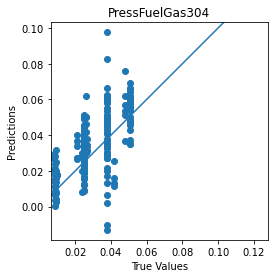

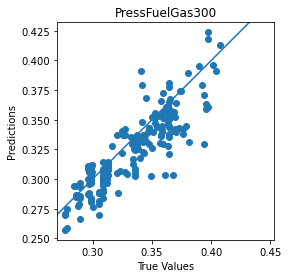

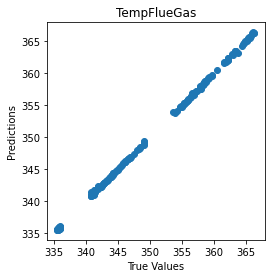

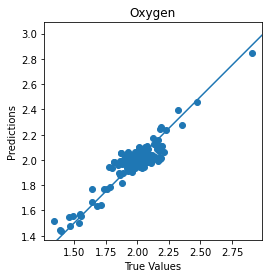

In [75]:
# Run predict
PressFuelGas304_output_pred = Y_pred[0]
PressFuelGas300_output_pred = Y_pred[1]
TempFlueGas_output_pred = Y_pred[2]
Oxygen_output_pred = Y_pred[3]


plot_diff(test_Y[0][:200], Y_pred[0][:200], title='PressFuelGas304')
plot_diff(test_Y[1][:200], Y_pred[1][:200], title='PressFuelGas300')
plot_diff(test_Y[2][:200], Y_pred[2][:200], title='TempFlueGas')
plot_diff(test_Y[3][:200], Y_pred[3][:200], title='Oxygen')

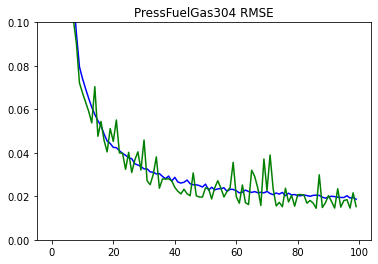

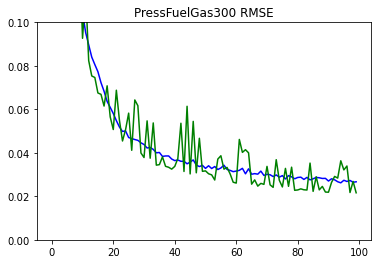

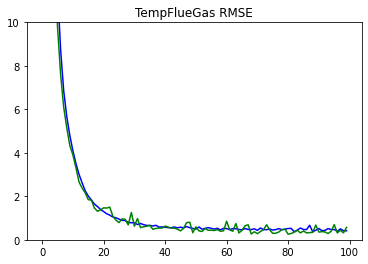

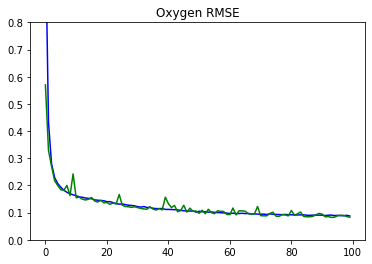

In [76]:
# Plot RMSE
plot_metrics(metric_name='PressFuelGas304_output_root_mean_squared_error', title='PressFuelGas304 RMSE', ylim=0.1)
plot_metrics(metric_name='PressFlueGas300_output_root_mean_squared_error', title='PressFuelGas300 RMSE', ylim=0.1)
plot_metrics(metric_name='TempFlueGas_output_root_mean_squared_error', title='TempFlueGas RMSE', ylim=10)
plot_metrics(metric_name='Oxygen_output_root_mean_squared_error', title='Oxygen RMSE', ylim=0.8)

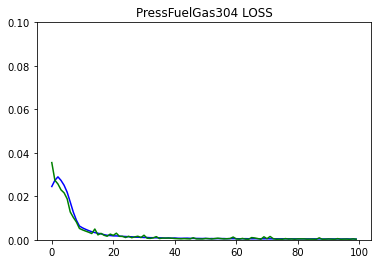

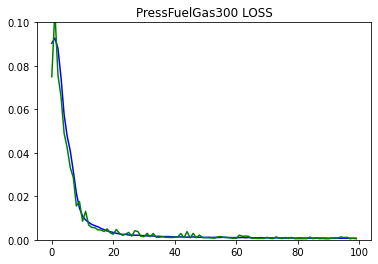

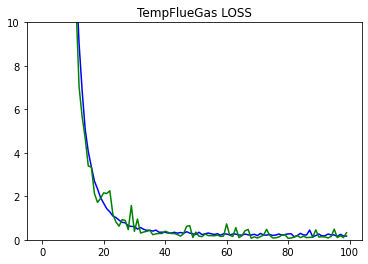

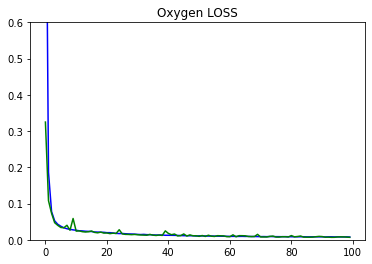

In [77]:
# Plot loss
plot_metrics(metric_name='PressFuelGas304_output_loss', title='PressFuelGas304 LOSS', ylim=(0.1))
plot_metrics(metric_name='PressFlueGas300_output_loss', title='PressFuelGas300 LOSS', ylim=0.1)
plot_metrics(metric_name='TempFlueGas_output_loss', title='TempFlueGas LOSS', ylim=10)
plot_metrics(metric_name='Oxygen_output_loss', title='Oxygen LOSS', ylim=0.6)

In [78]:
dff = df.shift(1)
dff = dff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)

dfff = df.shift(2)
dfff = dfff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)


dffff = df.shift(3)
dffff = dffff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)


dfffff = df.shift(4)
dfffff = dfffff.drop(['Temp flue gas/92ti300.pv', 'oxygen% /92ai300.pv','Press Fuel gas/92pi304.pv','Press flue gas/92pi300.pv'], axis=1)

pd.set_option('display.max_columns', None)

new_df = pd.concat([df,dff,dfff,dffff,dfffff], axis=1, ignore_index=True)
new_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-06-21 07:00:00,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,0.008244,3.716083,7.780427,628.271057,649.402649,0.310961,298.276672,597.732300,760.399780,335.989716,2.052690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:01,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,0.008244,3.716082,7.780427,628.270996,649.402527,0.310964,298.276703,597.732300,760.399963,335.989563,2.030534,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,3.716083,7.780427,628.271057,649.402649,298.276672,597.732300,760.399780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:02,355.905548,356.111176,401.347473,1.099927,9.716405,7.576205,0.008245,3.716082,7.780427,628.270935,649.402344,0.310968,298.276703,597.732239,760.400146,335.989410,2.018448,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,3.716082,7.780427,628.270996,649.402527,298.276703,597.732300,760.399963,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,3.716083,7.780427,628.271057,649.402649,298.276672,597.732300,760.399780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:03,355.934082,356.604675,401.223083,1.088136,9.716447,7.576221,0.008245,3.716082,7.780428,628.270874,649.402222,0.310972,298.276733,597.732239,760.400330,335.989258,2.016434,355.905548,356.111176,401.347473,1.099927,9.716405,7.576205,3.716082,7.780427,628.270935,649.402344,298.276703,597.732239,760.400146,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,3.716082,7.780427,628.270996,649.402527,298.276703,597.732300,760.399963,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,3.716083,7.780427,628.271057,649.402649,298.276672,597.732300,760.399780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-21 07:00:04,355.962616,355.491791,401.098724,1.083197,9.716489,7.576236,0.008246,3.716081,7.780428,628.270813,649.402100,0.310976,298.276733,597.732239,760.400513,335.989105,2.014420,355.934082,356.604675,401.223083,1.088136,9.716447,7.576221,3.716082,7.780428,628.270874,649.402222,298.276733,597.732239,760.400330,355.905548,356.111176,401.347473,1.099927,9.716405,7.576205,3.716082,7.780427,628.270935,649.402344,298.276703,597.732239,760.400146,355.877014,354.608063,401.471863,1.111719,9.716364,7.576190,3.716082,7.780427,628.270996,649.402527,298.276703,597.732300,760.399963,355.848480,352.095337,401.596222,1.123510,9.716322,7.576174,3.716083,7.780427,628.271057,649.402649,298.276672,597.732300,760.399780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-21 12:59:55,355.894012,355.310516,384.652435,1.079072,9.662274,6.908769,0.050951,3.449764,7.674482,633.258545,657.526001,0.317213,299.992676,605.804993,768.476746,355.115173,1.953448,356.169708,358.634003,384.401489,1.071057,9.662808,6.908772,3.449668,7.674482,633.258972,657.527405,299.992676,605.814148,768.477295,356.065216,359.391846,384.150543,1.063042,9.663342,6.908773,3.449571,7.674482,633.259460,657.528809,299.992676,605.823242,768.477905,355.580566,357.584076,383.899628,1.055027,9.663877,6.908776,3.449474,7.674482,633.259888,657.530212,299.992676,605.832397,768.478455,355.095886,355.776306,384.101471,1.052222,9.664411,6.

In [79]:
new_df = new_df.dropna()
# display(new_df)

In [80]:
train, test = train_test_split(new_df, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [81]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop( 5)
    y1 = np.array(y1)
    y2 = data.pop( 10)
    y2 = np.array(y2)
    y3 = data.pop( 14)
    y3 = np.array(y3)
    y4 = data.pop( 15)
    y4 = np.array(y4)
    
    return y1, y2, y3, y4

In [82]:
# Get the 4 outputs and format them as np arrays

train_stats = train.describe()
train_stats.pop( 5)
train_stats.pop( 10)
train_stats.pop( 14)
train_stats.pop( 15)
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)

      count        mean        std         min         25%         50%  \
0   13753.0  395.580261  44.927795  310.567108  367.302185  378.814819   
1   13753.0  396.748199  44.622417  338.026001  366.675781  376.449768   
2   13753.0  435.146088  43.133171  366.159363  409.978119  419.969299   
3   13753.0    1.377739   0.326100    0.999363    1.171243    1.221704   
4   13753.0   11.341774   2.123790    9.287875   10.004269   10.292412   
..      ...         ...        ...         ...         ...         ...   
64  13753.0  630.167358   5.278503  597.887512  627.563721  628.282166   
65  13753.0  656.882202   8.264924  643.708191  651.238892  651.576294   
66  13753.0  298.339600   1.204374  291.347595  298.179871  298.297882   
67  13753.0  615.817139  18.604506  597.643372  601.243103  605.904785   
68  13753.0  765.005554   3.310662  760.399780  762.409729  764.849854   

           75%         max  
0   408.699982  608.140686  
1   430.622284  570.761719  
2   458.444702  662.7767

In [83]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [84]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'PressFuelGas304_output': 'mse', 'PressFlueGas300_output': 'mse','TempFlueGas_output': 'mse','Oxygen_output': 'mse'},
              metrics={'PressFuelGas304_output': tf.keras.metrics.RootMeanSquaredError(),
                       'PressFlueGas300_output': tf.keras.metrics.RootMeanSquaredError(),
                       'TempFlueGas_output': tf.keras.metrics.RootMeanSquaredError(),
                       'Oxygen_output': tf.keras.metrics.RootMeanSquaredError()})
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 128)          8448        ['input_4[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 128)          16512       ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 128)          16512       ['dense_10[0][0]']               
                                                                                            

In [85]:
# Train the model for 50 epochs, 38
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/100
1376/1376 [==============================] - 5s 3ms/step - loss: 297499.5625 - PressFuelGas304_output_loss: 15.9209 - PressFlueGas300_output_loss: 114524.1953 - TempFlueGas_output_loss: 152452.2812 - Oxygen_output_loss: 30507.3223 - PressFuelGas304_output_root_mean_squared_error: 3.9901 - PressFlueGas300_output_root_mean_squared_error: 338.4142 - TempFlueGas_output_root_mean_squared_error: 390.4514 - Oxygen_output_root_mean_squared_error: 174.6635 - val_loss: 35518.5156 - val_PressFuelGas304_output_loss: 4.9690 - val_PressFlueGas300_output_loss: 13209.3301 - val_TempFlueGas_output_loss: 18329.0410 - val_Oxygen_output_loss: 3975.1721 - val_PressFuelGas304_output_root_mean_squared_error: 2.2291 - val_PressFlueGas300_output_root_mean_squared_error: 114.9318 - val_TempFlueGas_output_root_mean_squared_error: 135.3848 - val_Oxygen_output_root_mean_squared_error: 63.0490
Epoch 2/100
1376/1376 [==============================] - 3s 3ms/step - loss: 20023.4395 - PressFuelGas304_outpu

Epoch 20/100
1376/1376 [==============================] - 4s 3ms/step - loss: 88.0798 - PressFuelGas304_output_loss: 0.0805 - PressFlueGas300_output_loss: 33.0617 - TempFlueGas_output_loss: 43.9476 - Oxygen_output_loss: 10.9899 - PressFuelGas304_output_root_mean_squared_error: 0.2838 - PressFlueGas300_output_root_mean_squared_error: 5.7499 - TempFlueGas_output_root_mean_squared_error: 6.6293 - Oxygen_output_root_mean_squared_error: 3.3151 - val_loss: 89.0303 - val_PressFuelGas304_output_loss: 0.0996 - val_PressFlueGas300_output_loss: 34.2107 - val_TempFlueGas_output_loss: 44.1277 - val_Oxygen_output_loss: 10.5923 - val_PressFuelGas304_output_root_mean_squared_error: 0.3156 - val_PressFlueGas300_output_root_mean_squared_error: 5.8490 - val_TempFlueGas_output_root_mean_squared_error: 6.6429 - val_Oxygen_output_root_mean_squared_error: 3.2546
Epoch 21/100
1376/1376 [==============================] - 4s 3ms/step - loss: 77.0414 - PressFuelGas304_output_loss: 0.0708 - PressFlueGas300_output

Epoch 30/100
1376/1376 [==============================] - 4s 3ms/step - loss: 31.1020 - PressFuelGas304_output_loss: 0.0463 - PressFlueGas300_output_loss: 11.8245 - TempFlueGas_output_loss: 15.3553 - Oxygen_output_loss: 3.8759 - PressFuelGas304_output_root_mean_squared_error: 0.2152 - PressFlueGas300_output_root_mean_squared_error: 3.4387 - TempFlueGas_output_root_mean_squared_error: 3.9186 - Oxygen_output_root_mean_squared_error: 1.9687 - val_loss: 24.8833 - val_PressFuelGas304_output_loss: 0.0481 - val_PressFlueGas300_output_loss: 9.3752 - val_TempFlueGas_output_loss: 12.5011 - val_Oxygen_output_loss: 2.9589 - val_PressFuelGas304_output_root_mean_squared_error: 0.2192 - val_PressFlueGas300_output_root_mean_squared_error: 3.0619 - val_TempFlueGas_output_root_mean_squared_error: 3.5357 - val_Oxygen_output_root_mean_squared_error: 1.7202
Epoch 31/100
1376/1376 [==============================] - 4s 3ms/step - loss: 29.7841 - PressFuelGas304_output_loss: 0.0431 - PressFlueGas300_output_lo

Epoch 40/100
1376/1376 [==============================] - 4s 3ms/step - loss: 17.2276 - PressFuelGas304_output_loss: 0.0382 - PressFlueGas300_output_loss: 6.5486 - TempFlueGas_output_loss: 8.4642 - Oxygen_output_loss: 2.1765 - PressFuelGas304_output_root_mean_squared_error: 0.1955 - PressFlueGas300_output_root_mean_squared_error: 2.5590 - TempFlueGas_output_root_mean_squared_error: 2.9093 - Oxygen_output_root_mean_squared_error: 1.4753 - val_loss: 14.2970 - val_PressFuelGas304_output_loss: 0.0360 - val_PressFlueGas300_output_loss: 5.6473 - val_TempFlueGas_output_loss: 6.9472 - val_Oxygen_output_loss: 1.6665 - val_PressFuelGas304_output_root_mean_squared_error: 0.1898 - val_PressFlueGas300_output_root_mean_squared_error: 2.3764 - val_TempFlueGas_output_root_mean_squared_error: 2.6358 - val_Oxygen_output_root_mean_squared_error: 1.2909
Epoch 41/100
1376/1376 [==============================] - 4s 3ms/step - loss: 15.5229 - PressFuelGas304_output_loss: 0.0374 - PressFlueGas300_output_loss:

Epoch 50/100
1376/1376 [==============================] - 4s 3ms/step - loss: 11.9140 - PressFuelGas304_output_loss: 0.0335 - PressFlueGas300_output_loss: 4.5113 - TempFlueGas_output_loss: 5.8526 - Oxygen_output_loss: 1.5166 - PressFuelGas304_output_root_mean_squared_error: 0.1831 - PressFlueGas300_output_root_mean_squared_error: 2.1240 - TempFlueGas_output_root_mean_squared_error: 2.4192 - Oxygen_output_root_mean_squared_error: 1.2315 - val_loss: 7.3921 - val_PressFuelGas304_output_loss: 0.0255 - val_PressFlueGas300_output_loss: 2.7432 - val_TempFlueGas_output_loss: 3.6914 - val_Oxygen_output_loss: 0.9320 - val_PressFuelGas304_output_root_mean_squared_error: 0.1596 - val_PressFlueGas300_output_root_mean_squared_error: 1.6563 - val_TempFlueGas_output_root_mean_squared_error: 1.9213 - val_Oxygen_output_root_mean_squared_error: 0.9654
Epoch 51/100
1376/1376 [==============================] - 4s 3ms/step - loss: 11.5634 - PressFuelGas304_output_loss: 0.0328 - PressFlueGas300_output_loss: 

Epoch 60/100
1376/1376 [==============================] - 4s 3ms/step - loss: 10.4031 - PressFuelGas304_output_loss: 0.0299 - PressFlueGas300_output_loss: 3.9279 - TempFlueGas_output_loss: 5.1251 - Oxygen_output_loss: 1.3203 - PressFuelGas304_output_root_mean_squared_error: 0.1728 - PressFlueGas300_output_root_mean_squared_error: 1.9819 - TempFlueGas_output_root_mean_squared_error: 2.2639 - Oxygen_output_root_mean_squared_error: 1.1490 - val_loss: 6.4177 - val_PressFuelGas304_output_loss: 0.0530 - val_PressFlueGas300_output_loss: 2.4456 - val_TempFlueGas_output_loss: 3.1393 - val_Oxygen_output_loss: 0.7799 - val_PressFuelGas304_output_root_mean_squared_error: 0.2301 - val_PressFlueGas300_output_root_mean_squared_error: 1.5638 - val_TempFlueGas_output_root_mean_squared_error: 1.7718 - val_Oxygen_output_root_mean_squared_error: 0.8831
Epoch 61/100
1376/1376 [==============================] - 4s 3ms/step - loss: 10.2854 - PressFuelGas304_output_loss: 0.0304 - PressFlueGas300_output_loss: 

Epoch 70/100
1376/1376 [==============================] - 4s 3ms/step - loss: 7.9032 - PressFuelGas304_output_loss: 0.0277 - PressFlueGas300_output_loss: 2.9695 - TempFlueGas_output_loss: 3.8815 - Oxygen_output_loss: 1.0245 - PressFuelGas304_output_root_mean_squared_error: 0.1666 - PressFlueGas300_output_root_mean_squared_error: 1.7232 - TempFlueGas_output_root_mean_squared_error: 1.9702 - Oxygen_output_root_mean_squared_error: 1.0122 - val_loss: 16.2535 - val_PressFuelGas304_output_loss: 0.0300 - val_PressFlueGas300_output_loss: 6.2436 - val_TempFlueGas_output_loss: 8.0888 - val_Oxygen_output_loss: 1.8911 - val_PressFuelGas304_output_root_mean_squared_error: 0.1733 - val_PressFlueGas300_output_root_mean_squared_error: 2.4987 - val_TempFlueGas_output_root_mean_squared_error: 2.8441 - val_Oxygen_output_root_mean_squared_error: 1.3752
Epoch 71/100
1376/1376 [==============================] - 4s 3ms/step - loss: 7.5492 - PressFuelGas304_output_loss: 0.0281 - PressFlueGas300_output_loss: 2

Epoch 80/100
1376/1376 [==============================] - 4s 3ms/step - loss: 8.7065 - PressFuelGas304_output_loss: 0.0250 - PressFlueGas300_output_loss: 3.2707 - TempFlueGas_output_loss: 4.3051 - Oxygen_output_loss: 1.1057 - PressFuelGas304_output_root_mean_squared_error: 0.1581 - PressFlueGas300_output_root_mean_squared_error: 1.8085 - TempFlueGas_output_root_mean_squared_error: 2.0749 - Oxygen_output_root_mean_squared_error: 1.0515 - val_loss: 4.4636 - val_PressFuelGas304_output_loss: 0.0216 - val_PressFlueGas300_output_loss: 1.6770 - val_TempFlueGas_output_loss: 2.1213 - val_Oxygen_output_loss: 0.6437 - val_PressFuelGas304_output_root_mean_squared_error: 0.1469 - val_PressFlueGas300_output_root_mean_squared_error: 1.2950 - val_TempFlueGas_output_root_mean_squared_error: 1.4565 - val_Oxygen_output_root_mean_squared_error: 0.8023
Epoch 81/100
1376/1376 [==============================] - 4s 3ms/step - loss: 8.5198 - PressFuelGas304_output_loss: 0.0268 - PressFlueGas300_output_loss: 3.

Epoch 90/100
1376/1376 [==============================] - 4s 3ms/step - loss: 5.6641 - PressFuelGas304_output_loss: 0.0244 - PressFlueGas300_output_loss: 2.1017 - TempFlueGas_output_loss: 2.7898 - Oxygen_output_loss: 0.7481 - PressFuelGas304_output_root_mean_squared_error: 0.1563 - PressFlueGas300_output_root_mean_squared_error: 1.4497 - TempFlueGas_output_root_mean_squared_error: 1.6703 - Oxygen_output_root_mean_squared_error: 0.8649 - val_loss: 4.4428 - val_PressFuelGas304_output_loss: 0.0490 - val_PressFlueGas300_output_loss: 1.6134 - val_TempFlueGas_output_loss: 2.1782 - val_Oxygen_output_loss: 0.6022 - val_PressFuelGas304_output_root_mean_squared_error: 0.2214 - val_PressFlueGas300_output_root_mean_squared_error: 1.2702 - val_TempFlueGas_output_root_mean_squared_error: 1.4759 - val_Oxygen_output_root_mean_squared_error: 0.7760
Epoch 91/100
1376/1376 [==============================] - 4s 3ms/step - loss: 8.0031 - PressFuelGas304_output_loss: 0.0254 - PressFlueGas300_output_loss: 2.

Epoch 100/100
1376/1376 [==============================] - 4s 3ms/step - loss: 6.3919 - PressFuelGas304_output_loss: 0.0238 - PressFlueGas300_output_loss: 2.3765 - TempFlueGas_output_loss: 3.1759 - Oxygen_output_loss: 0.8157 - PressFuelGas304_output_root_mean_squared_error: 0.1543 - PressFlueGas300_output_root_mean_squared_error: 1.5416 - TempFlueGas_output_root_mean_squared_error: 1.7821 - Oxygen_output_root_mean_squared_error: 0.9031 - val_loss: 4.5993 - val_PressFuelGas304_output_loss: 0.0187 - val_PressFlueGas300_output_loss: 1.7322 - val_TempFlueGas_output_loss: 2.3323 - val_Oxygen_output_loss: 0.5160 - val_PressFuelGas304_output_root_mean_squared_error: 0.1369 - val_PressFlueGas300_output_root_mean_squared_error: 1.3161 - val_TempFlueGas_output_root_mean_squared_error: 1.5272 - val_Oxygen_output_root_mean_squared_error: 0.7184


# Results of the model with timesteps

In [86]:
# Test the model and print loss and rmse for ALL outputs
loss, Y1_loss, Y2_loss,Y3_loss, Y4_loss, Y1_rmse, Y2_rmse, Y3_rmse, Y4_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'PressFuelGas304_loss: {Y1_loss}')
print(f'PressFlueGas300_loss: {Y2_loss}')
print(f'TempFlueGas_loss: {Y3_loss}')
print(f'Oxygen_loss: {Y4_loss}')
print(f'PressFuelGas304_rmse: {Y1_rmse}')
print(f'PressFlueGas300_rmse: {Y2_rmse}')
print(f'TempFlueGas_rmse: {Y3_rmse}')
print(f'Oxygen_rmse: {Y4_rmse}')

108/108 [==============================] - 0s 2ms/step - loss: 4.2553 - PressFuelGas304_output_loss: 0.0203 - PressFlueGas300_output_loss: 1.5845 - TempFlueGas_output_loss: 2.1576 - Oxygen_output_loss: 0.4929 - PressFuelGas304_output_root_mean_squared_error: 0.1423 - PressFlueGas300_output_root_mean_squared_error: 1.2588 - TempFlueGas_output_root_mean_squared_error: 1.4689 - Oxygen_output_root_mean_squared_error: 0.7021

loss: 4.255256652832031
PressFuelGas304_loss: 0.020255649462342262
PressFlueGas300_loss: 1.5844682455062866
TempFlueGas_loss: 2.157585859298706
Oxygen_loss: 0.4929466247558594
PressFuelGas304_rmse: 0.1423223465681076
PressFlueGas300_rmse: 1.2587566375732422
TempFlueGas_rmse: 1.468872308731079
Oxygen_rmse: 0.7021015882492065
